<a href="https://colab.research.google.com/github/ericasagun/Intel-Image-Classification/blob/main/Image_Classification_Intel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Download data**
> Download the zipfile from https://www.kaggle.com/puneet6060/intel-image-classification to your local directory.
There are two ways to upload your data to Google Colab: 

1.   Upload from local via google.colab files.upload: since the zip file is large, this might take a while
2.   Upload from Google drive via PyDrive (faster way)





**First option**: via google.colab files.upload()

In [ ]:
# Upload downloaded zip file from https://www.kaggle.com/puneet6060/intel-image-classification
# Might take a while
from google.colab import files
uploaded = files.upload()

**Second option**: via PyDrive. Follow steps here https://buomsoo-kim.github.io/colab/2018/04/16/Importing-files-from-Google-Drive-in-Google-Colab.md/

In [ ]:
!pip install PyDrive

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
# After running this block, the files will be uploaded on the content folder
downloaded = drive.CreateFile({'id':'1CQg4lz1ck6JJ18c8tJwwUJ4nDMYTU3Gz'})
downloaded.GetContentFile('archive.zip')

**Unzipping file**

In [4]:
import os
import zipfile

In [5]:
local_zip = 'archive.zip'
base_dir = './tmp/intel-images'

In [6]:
zip_file = zipfile.ZipFile(local_zip, 'r')
zip_file.extractall(base_dir)
zip_file.close()

In [7]:
train_dir = os.path.join(base_dir, 'seg_train/seg_train')
test_dir = os.path.join(base_dir, 'seg_test/seg_test')

buildings_dir = os.path.join(train_dir, 'buildings')
forest_dir = os.path.join(train_dir, 'forest')
glacier_dir = os.path.join(train_dir, 'glacier')
mountain_dir = os.path.join(train_dir, 'mountain')
sea_dir = os.path.join(train_dir, 'sea')
street_dir = os.path.join(train_dir, 'street')

buildings_fnames = os.listdir(buildings_dir)
forest_fnames = os.listdir(forest_dir)
glacier_fnames = os.listdir(glacier_dir)
mountain_fnames = os.listdir(mountain_dir)
sea_fnames = os.listdir(sea_dir)
street_fnames = os.listdir(street_dir)

In [8]:
print('Total building training images:', len(buildings_fnames))
print('Total forest training images:',   len(forest_fnames))
print('Total glacier training images:',  len(glacier_fnames))
print('Total mountain training images:', len(mountain_fnames))
print('Total sea training images:',      len(sea_fnames))
print('Total street training images:',   len(street_fnames))

print('Total training images:', len(buildings_fnames)+len(forest_fnames)+len(glacier_fnames)+len(mountain_fnames)\
                                +len(sea_fnames)+len(street_fnames))

Total building training images: 2191
Total forest training images: 2271
Total glacier training images: 2404
Total mountain training images: 2512
Total sea training images: 2274
Total street training images: 2382
Total training images: 14034


**Visualize data**

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

nrows, ncols, = 4, 4
pic_index = 0

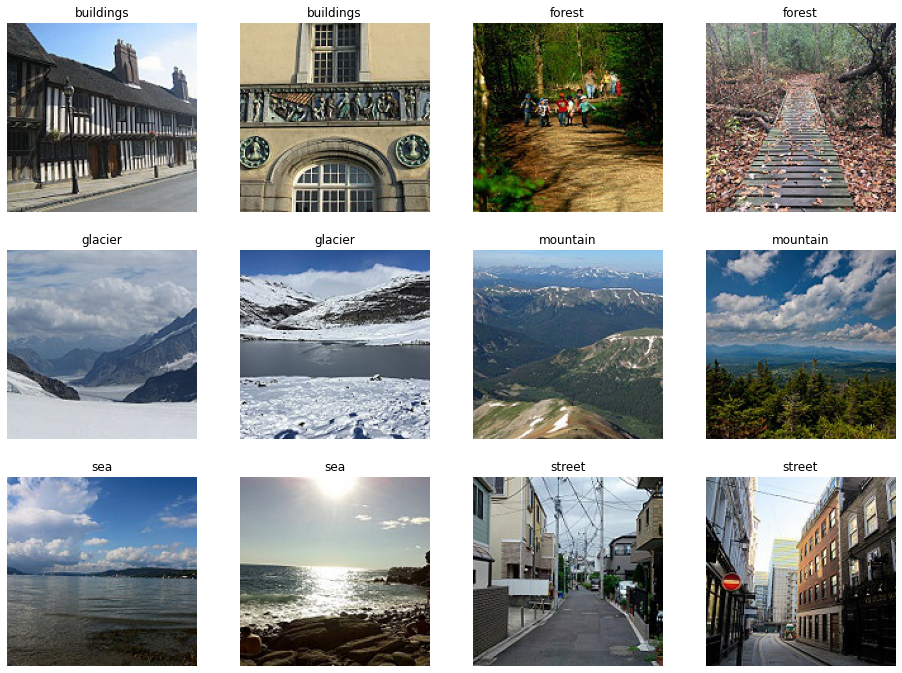

In [10]:
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 2

next_building_pic = [os.path.join(buildings_dir, fname) for fname in buildings_fnames[pic_index-2:pic_index]]
next_forest_pic   = [os.path.join(forest_dir, fname) for fname in forest_fnames[pic_index-2:pic_index]]
next_glacier_pic  = [os.path.join(glacier_dir, fname) for fname in glacier_fnames[pic_index-2:pic_index]]
next_mountain_pic = [os.path.join(mountain_dir, fname) for fname in mountain_fnames[pic_index-2:pic_index]]
next_sea_pic      = [os.path.join(sea_dir, fname) for fname in sea_fnames[pic_index-2:pic_index]]
next_street_pic   = [os.path.join(street_dir, fname) for fname in street_fnames[pic_index-2:pic_index]]

next_img = next_building_pic + next_forest_pic + next_glacier_pic + next_mountain_pic + next_sea_pic + next_street_pic

for i, img_path in enumerate(next_img):
  ax = plt.subplot(nrows, ncols, i+1)
  ax.axis('Off')

  path = Path(img_path)

  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.title(str(path.parent)[37:])
plt.show()

**Preprocess data**

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
import numpy as np

In [12]:
batch_size = 125

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    class_mode='categorical',
    batch_size=batch_size,
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    class_mode='categorical',
    batch_size=batch_size,
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


**Define model**


In [15]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [14]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-04-06 14:04:43--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.167.128, 74.125.133.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

tmp/inception_v3_we 100%[===================>]  83.84M   200MB/s    in 0.4s    

2021-04-06 14:04:44 (200 MB/s) - ‘tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [17]:
local_weights_file = 'tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pretrained_model = InceptionV3(input_shape=(150,150,3), include_top=False, weights=None)
pretrained_model.load_weights(local_weights_file)

for layer in pretrained_model.layers:
  layer.trainable = False

last_layer = pretrained_model.get_layer('mixed7')
last_output = last_layer.output

In [23]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(6, activation='softmax')(x)

model = Model(pretrained_model.input, x)

In [34]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics='accuracy')

**Define Callback function**

In [24]:
class Callback_(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs['accuracy'] > 0.99:
      print('Training accuracy reached 99%. Stopping training!')
      self.model.stop_training = True

In [27]:
callbacks = Callback_()

STEPS_PER_EPOCH = 11230//125
VALIDATION_STEPS = 2804//125

**Train model**

In [31]:
history = model.fit(
        train_generator,
        epochs=20,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_data=validation_generator,
        validation_steps=VALIDATION_STEPS,
        verbose=1,
        callbacks=[callbacks]
    )

Epoch 1/20
89/89 [==============================] - 63s 319ms/step - loss: 5.1492 - accuracy: 0.7060 - val_loss: 0.3973 - val_accuracy: 0.8582
Epoch 2/20
89/89 [==============================] - 26s 292ms/step - loss: 0.3540 - accuracy: 0.8872 - val_loss: 0.7917 - val_accuracy: 0.8218
Epoch 3/20
89/89 [==============================] - 26s 293ms/step - loss: 0.2570 - accuracy: 0.9169 - val_loss: 0.6435 - val_accuracy: 0.8429
Epoch 4/20
89/89 [==============================] - 26s 295ms/step - loss: 0.1705 - accuracy: 0.9399 - val_loss: 0.4428 - val_accuracy: 0.8840
Epoch 5/20
89/89 [==============================] - 26s 297ms/step - loss: 0.1531 - accuracy: 0.9480 - val_loss: 0.3937 - val_accuracy: 0.9153
Epoch 6/20
89/89 [==============================] - 26s 296ms/step - loss: 0.0950 - accuracy: 0.9676 - val_loss: 0.8009 - val_accuracy: 0.8542
Epoch 7/20
89/89 [==============================] - 26s 295ms/step - loss: 0.0774 - accuracy: 0.9720 - val_loss: 0.4836 - val_accuracy: 0.9138

**Plot accuracy and loss**

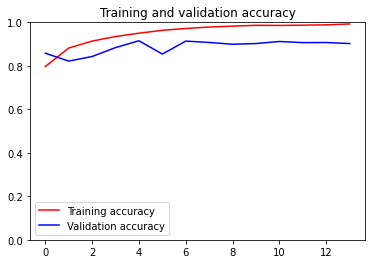

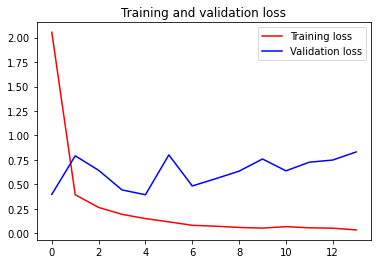

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylim([0,1])
plt.legend(loc=0)
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

**Test model**

In [33]:
model.evaluate(test_generator)

24/24 [==============================] - 5s 214ms/step - loss: 0.7872 - accuracy: 0.9120


[0.7872035503387451, 0.9120000004768372]